# SERIMATS Application


|           |                |
| : ----- : | :------------: |
| Candidate | Matthieu David |
| stream    | developmental interpretability |
| subject   | [task variability](https://devinterp.com/projects/task-variability) |



This notebook is inspired from the notebook [RLCT Estimation of MNIST](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/mnist.ipynb) with large change to fit my submission.


---
## RLCT Estimation of MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]()

This Jupyter Notebook aims to reproduce the results of Lau et al. (2023) by measuring the Real Log Canonical Threshold (RLCT) for a small 2-layer ReLU model (about 1M parameters) trained on the MNIST dataset. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

---

## Table of Contents:
* packages installation
* Import for the all notebook
* Method definitions
* Experiments 1 (XP1): Impact of the number of classes
    * Toy model and Resnet18 instances
    * Settings and runs label sets $Card(\mathcal{L}abels) = 2$
    * Settings and runs label sets $Card(\mathcal{L}abels) = 3$
    * Settings and runs label sets $Card(\mathcal{L}abels) = 4$
    * Settings and runs label sets $Card(\mathcal{L}abels) = 5$
    * Settings and runs label sets $Card(\mathcal{L}abels) = 6$
    * Settings and runs label sets $Card(\mathcal{L}abels) = 10$
* Displays $λ\ vs\ \mathcal{L}abels$
* Experiments 2 (XP2): Impact of the data diversity
* Experiments 3 (XP3): Impact of the number of classes

---

## Package installation:

In [ ]:
%pip install devinterp matplotlib seaborn torchvision

## Import for all the notebook

In [2]:
import copy
import matplotlib.pyplot as plt

import os
from pydantic.types import confloat, conint
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import Literal

from torchvision import datasets, transforms
from torchvision.models import resnet18

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]
sns.set_theme("paper")

## Method definitions

#### Class of the Toy model:
The toy model corresponds to the initial model used in the notebook RLCT Estimation of MNIST (rewrite a little for lisibility). This model is made of 2 linear layers, each activations being a ReLU function:

In [3]:

# Define the toy neural network
class OriginalToyNet(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(OriginalToyNet, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

# Define the toy neural network
class ToyNet(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        with_bias=True,
    ):
        super(ToyNet, self).__init__()
        self.input_dim = input_dim
        self.with_bias = with_bias
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]

        # First basic block = Linear + ReLU activation
        self.fc_1 = nn.Linear(in_features=input_dim, out_features=1024, bias=self.with_bias)
        self.relu_1 = nn.ReLU()

        # 2nd basic block = Linear + ReLU activation
        self.fc_2 = nn.Linear(in_features=1024, out_features=1024, bias=self.with_bias)
        self.relu_2 = nn.ReLU()

        # Last Fully Connected layer:
        self.fc_3 = nn.Linear(in_features=1024, out_features=output_dim, bias=self.with_bias)



    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.fc_1(x)
        x = self.relu_1(x)
        x = self.fc_2(x)
        x = self.relu_2(x)
        x = self.relu_2(x)

        x = self.fc_3(x)
        return x

In [12]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    "Original train_one_epoch method from MNIST notebook of timaeus/devinterp"
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    "Original evaluate method from MNIST notebook of timaeus/devinterp"
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


def train_step(model, optimizer, criterion, train_set):
    model.train()
    # model.to(DEVICE)

    train_loss, train_acc = 0.0, 0.0
    i = 0
    prog_bar = tqdm(train_set, desc=f"\ttrain_loss: {train_loss:0.2f} -- train_acc: {train_acc:0.2f} %")
    for x, y in prog_bar:
        # Stating variables
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad() # Clear gradients
        output = model(x) # Forward step
        loss = criterion(output, y) # Loss step

        # Backward step
        loss.backward()
        optimizer.step()

        # Accuracy
        top_p, prediction = output.topk(1, dim=1)
        equals = (prediction == y.view(*prediction.shape))

        prog_bar.set_description(f"\ttrain_loss: {train_loss / len(train_set) :0.5f} -- train_acc: {100 * train_acc / len(train_set) :0.2f} %")
        # Saving data
        train_loss += loss.item()
        train_acc += torch.mean(equals.type(torch.FloatTensor))

    return train_loss / len(train_set), train_acc / len(train_set)


def val_step(model, criterion, val_set):
    val_loss, val_acc = 0.0, 0.0

    model.eval()
    # model.to(DEVICE)
    with torch.no_grad():
        for i, (x, y) in enumerate(val_set):
            # Stating variables
            images = x.to(DEVICE)
            labels = y.to(DEVICE)

            output = model(images) # Forward step

            loss = criterion(output, labels) # Loss step

            # Accuracy
            top_p, prediction = output.topk(1, dim=1)
            equals = (prediction == labels.view(*prediction.shape))

            # Saving data
            val_loss += loss.item()
            val_acc += torch.mean(equals.type(torch.FloatTensor))

    return val_loss / len(val_set), val_acc / len(val_set)

def print_step_report(epoch:int, train_loss: float, val_loss: float, train_acc: float, val_acc: float):
    print(f"Epoch {epoch+1}:\n" \
          f"Train Loss: {train_loss:.5f}" \
          f"-- Val Loss: {val_loss:.5f}" \
          f"-- Train Acc: {train_acc:0.2f}" \
          f"-- Val Acc: {val_acc:0.2f}")
    
def plot_lambda_vs_epochs(train_losses, test_losses, rlct_estimates_sgnht, rlct_estimates_sgld):
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=PRIMARY)
    ax1.plot(train_losses, label="Train Loss", color=PRIMARY)
    ax1.plot(test_losses, label="Test Loss", color=PRIMARY_LIGHT)
    ax1.tick_params(axis="y", labelcolor=PRIMARY)
    ax1.legend(loc="lower left")

    ax2 = ax1.twinx()
    ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
    ax2.plot(rlct_estimates_sgnht, label="SGNHT", color=SECONDARY)
    ax2.plot(rlct_estimates_sgld, label="SGLD", color=SECONDARY_LIGHT)
    ax2.tick_params(axis="y", labelcolor=SECONDARY)
    ax2.legend(loc="center right")

    fig.tight_layout()
    plt.show()

## Experiments 1 (XP1): Impact of the number of classes

This section contains all the experiments about the XP1 detailled in the application report [here](link)

First basic code cells are given the dataset MNIST and basics training with the Toy model and Resnet18 are reported. The readers can explore the core process without modifying the code for the actual experiment.

Secondly each sub experiments possess a dedicated sub section , new data loaders are generated, where the labels are rewritten to performed the experiment with the dedicated label set cardinality.

### MNIST dataset

In [4]:
# Load MNIST data
## definition of the transformation to apply to dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.244, 0.225]),
    ]
)

## Load train data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Toy model and Resnet18 instances

In [5]:
# Depending of the run type, cuda or cpu mode is defined
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------------------------------
N_CLASSES = 10 # for the 10 class digits of MNIST
lr = 0.005
n_epochs = 20
# --------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
model_resnet18 = resnet18(weights=None).to(DEVICE)

## changing the last fully connected layer of N neurons, each corresponding to a class.
new_fc_act = nn.Linear(model_resnet18.fc.in_features, N_CLASSES)
model_resnet18.fc = new_fc_act

## Changing the first conv2d layer to match the input image shape
model_resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Loss and optimizer definition
criterion_resnet18 = nn.CrossEntropyLoss()
optimizer_resnet18 = optim.SGD(model_resnet18.parameters(), lr=lr, momentum=0.9, nesterov=True)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

# Initialize model, loss, optimizer and sgld sampler
model_toy = ToyNet().to(DEVICE)
criterion_toy = nn.CrossEntropyLoss()
optimizer_toy = optim.SGD(model_toy.parameters(), lr=lr, momentum=0.9, nesterov=True)

In [8]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_toy = []
val_losses_toy = []
models_toy = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy.append(train_loss)
    val_losses_toy.append(val_loss)
    models_toy += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy, "toy_models.pth")

	train_loss: 1.96871 -- train_acc: 55.33 %: 100%|██████████| 118/118 [00:07<00:00, 14.82it/s]


Epoch 1:
Train Loss: 1.97890-- Val Loss: 1.25704-- Train Acc: 0.56-- Val Acc: 0.77


	train_loss: 0.75652 -- train_acc: 82.13 %: 100%|██████████| 118/118 [00:08<00:00, 14.69it/s]


Epoch 2:
Train Loss: 0.76113-- Val Loss: 0.50858-- Train Acc: 0.83-- Val Acc: 0.87


	train_loss: 0.45147 -- train_acc: 86.98 %: 100%|██████████| 118/118 [00:07<00:00, 14.75it/s]


Epoch 3:
Train Loss: 0.45447-- Val Loss: 0.39297-- Train Acc: 0.88-- Val Acc: 0.89


	train_loss: 0.37695 -- train_acc: 88.61 %: 100%|██████████| 118/118 [00:08<00:00, 14.49it/s]


Epoch 4:
Train Loss: 0.37959-- Val Loss: 0.34784-- Train Acc: 0.89-- Val Acc: 0.90


	train_loss: 0.33966 -- train_acc: 89.46 %: 100%|██████████| 118/118 [00:08<00:00, 14.68it/s]


Epoch 5:
Train Loss: 0.34318-- Val Loss: 0.31985-- Train Acc: 0.90-- Val Acc: 0.91


	train_loss: 0.31558 -- train_acc: 90.15 %: 100%|██████████| 118/118 [00:08<00:00, 14.56it/s]


Epoch 6:
Train Loss: 0.31817-- Val Loss: 0.30311-- Train Acc: 0.91-- Val Acc: 0.91


	train_loss: 0.29730 -- train_acc: 90.64 %: 100%|██████████| 118/118 [00:08<00:00, 14.48it/s]


Epoch 7:
Train Loss: 0.30044-- Val Loss: 0.28510-- Train Acc: 0.91-- Val Acc: 0.92


	train_loss: 0.28198 -- train_acc: 91.07 %: 100%|██████████| 118/118 [00:07<00:00, 14.99it/s]


Epoch 8:
Train Loss: 0.28399-- Val Loss: 0.27322-- Train Acc: 0.92-- Val Acc: 0.92


	train_loss: 0.26824 -- train_acc: 91.52 %: 100%|██████████| 118/118 [00:07<00:00, 14.79it/s]


Epoch 9:
Train Loss: 0.27011-- Val Loss: 0.26061-- Train Acc: 0.92-- Val Acc: 0.93


	train_loss: 0.25574 -- train_acc: 91.85 %: 100%|██████████| 118/118 [00:08<00:00, 14.36it/s]


Epoch 10:
Train Loss: 0.25836-- Val Loss: 0.24970-- Train Acc: 0.93-- Val Acc: 0.93


	train_loss: 0.24429 -- train_acc: 92.17 %: 100%|██████████| 118/118 [00:08<00:00, 14.40it/s]


Epoch 11:
Train Loss: 0.24662-- Val Loss: 0.23799-- Train Acc: 0.93-- Val Acc: 0.93


	train_loss: 0.23380 -- train_acc: 92.52 %: 100%|██████████| 118/118 [00:08<00:00, 14.60it/s]


Epoch 12:
Train Loss: 0.23596-- Val Loss: 0.22966-- Train Acc: 0.93-- Val Acc: 0.93


	train_loss: 0.22402 -- train_acc: 92.73 %: 100%|██████████| 118/118 [00:08<00:00, 14.52it/s]


Epoch 13:
Train Loss: 0.22514-- Val Loss: 0.22207-- Train Acc: 0.94-- Val Acc: 0.94


	train_loss: 0.21462 -- train_acc: 93.13 %: 100%|██████████| 118/118 [00:08<00:00, 14.40it/s]


Epoch 14:
Train Loss: 0.21594-- Val Loss: 0.21328-- Train Acc: 0.94-- Val Acc: 0.94


	train_loss: 0.20578 -- train_acc: 93.32 %: 100%|██████████| 118/118 [00:08<00:00, 14.21it/s]


Epoch 15:
Train Loss: 0.20827-- Val Loss: 0.20841-- Train Acc: 0.94-- Val Acc: 0.94


	train_loss: 0.19761 -- train_acc: 93.50 %: 100%|██████████| 118/118 [00:08<00:00, 14.13it/s]


Epoch 16:
Train Loss: 0.19937-- Val Loss: 0.19695-- Train Acc: 0.94-- Val Acc: 0.94


	train_loss: 0.18970 -- train_acc: 93.81 %: 100%|██████████| 118/118 [00:08<00:00, 14.44it/s]


Epoch 17:
Train Loss: 0.19120-- Val Loss: 0.18987-- Train Acc: 0.95-- Val Acc: 0.95


	train_loss: 0.18245 -- train_acc: 93.98 %: 100%|██████████| 118/118 [00:08<00:00, 14.42it/s]


Epoch 18:
Train Loss: 0.18419-- Val Loss: 0.18364-- Train Acc: 0.95-- Val Acc: 0.95


	train_loss: 0.17552 -- train_acc: 94.17 %: 100%|██████████| 118/118 [00:08<00:00, 14.48it/s]


Epoch 19:
Train Loss: 0.17789-- Val Loss: 0.17893-- Train Acc: 0.95-- Val Acc: 0.95


	train_loss: 0.16919 -- train_acc: 94.32 %: 100%|██████████| 118/118 [00:08<00:00, 14.48it/s]


Epoch 20:
Train Loss: 0.17065-- Val Loss: 0.17304-- Train Acc: 0.95-- Val Acc: 0.95


In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet = []
val_losses_resnet = []
models_resnet = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet.append(train_loss)
    val_losses_resnet.append(val_loss)
    models_resnet += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet, "resnet_models.pth")

In [10]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
from devinterp.slt import estimate_learning_coeff

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

Chain 0: 100%|██████████| 400/400 [00:21<00:00, 18.19it/s]


-3852.753343997854 -3640.6311858962777


Chain 0: 100%|██████████| 400/400 [00:22<00:00, 17.69it/s]


-436.58620561185614 -329.491651748154


Chain 0: 100%|██████████| 400/400 [00:21<00:00, 18.34it/s]


-42.85395918595251 -194.26585889932025


Chain 0: 100%|██████████| 400/400 [00:21<00:00, 18.89it/s]


82.4119623067347 404.82696038956095


Chain 0: 100%|██████████| 400/400 [00:21<00:00, 18.42it/s]


46.54318369194154 253.4161431066567


Chain 0: 100%|██████████| 400/400 [00:20<00:00, 19.44it/s]


428.6810660086328 360.67679072405326


Chain 0: 100%|██████████| 400/400 [00:21<00:00, 18.56it/s]


-265.8484144432344 132.46143366163642


Chain 0: 100%|██████████| 400/400 [00:21<00:00, 18.41it/s]


202.74238607693155 194.0227004848846


Chain 0: 100%|██████████| 400/400 [00:21<00:00, 18.39it/s]


369.38427825118555 329.50328259350164


Chain 0: 100%|██████████| 400/400 [00:21<00:00, 18.19it/s]


251.7312423714336 350.56211291790925


Chain 0: 100%|██████████| 400/400 [00:22<00:00, 18.13it/s]


492.52390588822175 220.42899429294874


Chain 0: 100%|██████████| 400/400 [00:22<00:00, 18.06it/s]


374.93267743802096 355.43272596343417


Chain 0: 100%|██████████| 400/400 [00:22<00:00, 17.83it/s]


543.4093219557976 692.1764810029241


Chain 0: 100%|██████████| 400/400 [00:22<00:00, 17.43it/s]


327.3843725470063 480.0516606059271


Chain 0: 100%|██████████| 400/400 [00:22<00:00, 17.75it/s]


53.565996193356376 38.732387208253215


Chain 0: 100%|██████████| 400/400 [00:24<00:00, 16.45it/s]


51.16224745535358 489.0264150043629


Chain 0: 100%|██████████| 400/400 [00:23<00:00, 17.01it/s]


515.0652988389887 523.9925032942607


Chain 0: 100%|██████████| 400/400 [00:24<00:00, 16.16it/s]


354.68736186800925 708.7104350637599


Chain 0: 100%|██████████| 400/400 [00:23<00:00, 16.83it/s]


268.6538515414521 538.7808726588772


Chain 0: 100%|██████████| 400/400 [00:24<00:00, 16.04it/s]

239.61094006985374 424.3772621491856


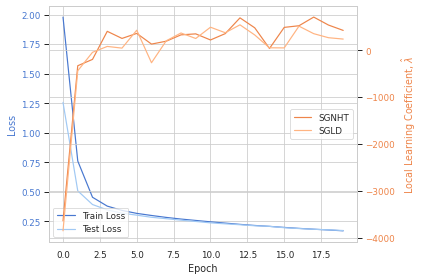

In [13]:
plot_lambda_vs_epochs(train_losses_toy, val_losses_toy, rlct_estimates_sgnht, rlct_estimates_sgld)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ______________________    Resnet18 models    ______________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
from devinterp.slt import estimate_learning_coeff

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_resnet:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_resnet18,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_resnet18,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

### Settings and runs label sets $Card(\mathcal{L}abels)=2$

The different sets of labels to explore are: $\{1, other\}$ ; $\{2, other\}$ ; $\{4, other\}$ ; $\{5, other\}$ ; $\{9, other\}$.
`other` cannot be put as a label as it, it needs to be encoded into a integer. In order to relabel as we wish, we simply map the first label/digit of the sets to `1` and all the other to `0`. For example for the set $\{4,other\}$ it means that the images representing `4` will be relabeled as `1` and the images representing any of $[0, 1, 2, 3, 5, 6, 7, 8, 9]$ will be relabeled as `0`.

* labels modification and data loader
* Run for the toy model
* Run for the resnet18 model

In [ ]:
# preparing the output directories of XP1
dirs = ["XP1",
        "XP1/card_2-case_1", "XP1/card_2-case_2","XP1/card_2-case_3", "XP1/card_2-case_4", "XP1/card_2-case_5",
        "XP1/card_3-case_1", "XP1/card_3-case_2","XP1/card_3-case_3", "XP1/card_3-case_4", "XP1/card_3-case_5",
        "XP1/card_4-case_1", "XP1/card_4-case_2","XP1/card_4-case_3", "XP1/card_4-case_4", "XP1/card_4-case_5",
        "XP1/card_5-case_1", "XP1/card_5-case_2","XP1/card_5-case_3", "XP1/card_5-case_4", "XP1/card_5-case_5",
        "XP1/card_10-case_1", "XP1/card_10-case_2","XP1/card_10-case_3", "XP1/card_10-case_4", "XP1/card_10-case_5"]

for path in dirs:
        os.mkdir(path)

In [25]:
def load_and_process_data(bs: int, mapping_label_to_encode: dict) -> tuple[DataLoader, DataLoader]:
    """ Loads MNIST dataset, relabel the images of train and test sets

    Function load MNIST dataset and performs the relabelling. The loading performs the transformation
    necessary to normalize the data distribution.
    Before forging the data loaders, the operation of relabelling to execute the experiments
    is performed.
    Arguments:
        bs: batch size, excepting a positive integer
        mapping_label_to_encode: mapping between original labels and target labels

    Returns:
        train_loader, test_loader: data loader of train and test
    """
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    # Load train data
    train_data = datasets.MNIST("../data", train=True, transform=transform, download=True)
    for old_label, new_label in mapping_label_to_encode.items():
        train_data.targets[train_data.targets == old_label] = new_label
    print("set of labels in train data: ", train_data.targets.unique())
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Load test data
    test_data = datasets.MNIST("../data", train=False, transform=transform)
    for old_label, new_label in mapping_label_to_encode.items():
        test_data.targets[test_data.targets == old_label] = new_label
    print("set of labels in test data: ", test_data.targets.unique())
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def models_factory(model_type: Literal["toy_model", "resnet18"],
                   optim_cfg: dict,
                   optim_name: Literal['SGD'] = "SGD",
                   criterion_name: Literal["CrossEntropyLoss"]="CrossEntropyLoss",
                   lr: confloat(gt=0, lt=1)=0.005,
                   n_epochs: conint(gt=0)=20,
                   nb_classes: conint(ge=2, le=10)=10
                   ):
    """Very light factory to handle the model instanciation.

    The main purpose of this method is to centralize the models instance
    allowing lighter code cells in the following.

    Note:
        versatility is very limited here, but the idea is to use a common interface to
        generate a model withing a collection of possibility

    Args:
        model_type: name of the model to return
        optim_name: optimiser name of the model
        optim_cfg: configuration of the optimiser
        criterion_name: Loss function associated with the model for training.
            Defaults to "CrossEntropyLoss".
        lr: learning rate. Defaults to 0.005.
        n_epochs: number of epochs. Defaults to 20.
        nb_classes: number of classes of the task.
    """
    if model_type == "toy_model":
        model_toy = ToyNet(output_dim=2).to(DEVICE)
    elif model_type == "resnet18":
        model_resnet18 = resnet18(weights=None).to(DEVICE)

        ## changing the last fully connected layer of N neurons, each corresponding to a class.
        new_fc_act = nn.Linear(model_resnet18.fc.in_features, N_CLASSES)
        model_resnet18.fc = new_fc_act

        ## Changing the first conv2d layer to match the input image shape
        model_resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    else:
        raise ValueError(f"Model factory does not handle model_type: '{model_type}'")
        
    # Loss definition
    if criterion_name == "CrossEntropyLoss":
        criterion = nn.CrossEntropyLoss()
    else:
        ValueError("Model factory only handles Cross Entropy Loss.")
    
    # Optimizer definition
    if optim_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, **optim_cfg)
    else:
        ValueError("Model factory only handles Cross Entropy Loss.")

    return model, optimizer, criterion

In [23]:
# keys are the original label, values are the new labels
map_label_card_2_1 = {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_2_2 = {1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_2_3 = {1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_2_4 = {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_2_5 = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1}

##### 1.1 XP1 - labels set $\mathcal{Card} = 2$ - $\mathcal{L}abels=\{1, other\}$

In [30]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## definition of the transformation to apply to dataset


## Load train data
batch_size = 512

train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_2_1)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 2
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}

model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

set of labels in train data:  tensor([0, 1])
set of labels in test data:  tensor([0, 1])


In [31]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

# train_losses_resnet_xp1_1 = []
# val_losses_resnet_xp1_1 = []
# models_resnet_xp1_1 = []
# for epoch in range(n_epochs):
#     train_loss, train_acc = train_step(model_resnet18,
#                                        optimizer_resnet18,
#                                        criterion_resnet18,
#                                        train_loader)
#     val_loss, val_acc = val_step(model_resnet18,
#                                   criterion_resnet18,
#                                   test_loader)
#     train_losses_resnet_xp1_1.append(train_loss)
#     val_losses_resnet_xp1_1.append(val_loss)
#     models_resnet_xp1_1 += [copy.deepcopy(model_resnet18)]

#     print_step_report(epoch=epoch,
#                       train_loss=train_loss,
#                       val_loss=val_loss,
#                       train_acc=train_acc,
#                       val_acc=val_acc)

# torch.save(models_resnet_xp1_1, "XP1/card_2-case_1/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_1 = []
val_losses_toy_xp1_1 = []
models_toy_xp1_1 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_1.append(train_loss)
    val_losses_toy_xp1_1.append(val_loss)
    models_toy_xp1_1 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_1, "XP1/card_2-case_1/toy_models.pth")

	train_loss: 0.41162 -- train_acc: 96.63 %: 100%|██████████| 118/118 [00:10<00:00, 11.42it/s]


Epoch 1:
Train Loss: 0.41163-- Val Loss: 0.02919-- Train Acc: 0.97-- Val Acc: 0.99


	train_loss: 0.03029 -- train_acc: 98.49 %: 100%|██████████| 118/118 [00:10<00:00, 11.41it/s]


Epoch 2:
Train Loss: 0.03032-- Val Loss: 0.01886-- Train Acc: 0.99-- Val Acc: 1.00


	train_loss: 0.02211 -- train_acc: 98.60 %: 100%|██████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch 3:
Train Loss: 0.02218-- Val Loss: 0.01674-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01870 -- train_acc: 98.64 %: 100%|██████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 4:
Train Loss: 0.01875-- Val Loss: 0.01486-- Train Acc: 0.99-- Val Acc: 1.00


	train_loss: 0.01643 -- train_acc: 98.70 %: 100%|██████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 5:
Train Loss: 0.01645-- Val Loss: 0.01382-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01466 -- train_acc: 98.74 %: 100%|██████████| 118/118 [00:10<00:00, 11.37it/s]


Epoch 6:
Train Loss: 0.01502-- Val Loss: 0.01276-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01341 -- train_acc: 98.76 %: 100%|██████████| 118/118 [00:10<00:00, 11.23it/s]


Epoch 7:
Train Loss: 0.01360-- Val Loss: 0.01196-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01230 -- train_acc: 98.78 %: 100%|██████████| 118/118 [00:10<00:00, 11.17it/s]


Epoch 8:
Train Loss: 0.01236-- Val Loss: 0.01136-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01135 -- train_acc: 98.83 %: 100%|██████████| 118/118 [00:10<00:00, 11.25it/s]


Epoch 9:
Train Loss: 0.01141-- Val Loss: 0.01088-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01056 -- train_acc: 98.84 %: 100%|██████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch 10:
Train Loss: 0.01062-- Val Loss: 0.01048-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00990 -- train_acc: 98.86 %: 100%|██████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch 11:
Train Loss: 0.00991-- Val Loss: 0.01013-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00925 -- train_acc: 98.89 %: 100%|██████████| 118/118 [00:10<00:00, 11.20it/s]


Epoch 12:
Train Loss: 0.00927-- Val Loss: 0.00990-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00871 -- train_acc: 98.90 %: 100%|██████████| 118/118 [00:10<00:00, 11.24it/s]


Epoch 13:
Train Loss: 0.00874-- Val Loss: 0.00954-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00829 -- train_acc: 98.92 %: 100%|██████████| 118/118 [00:10<00:00, 11.18it/s]


Epoch 14:
Train Loss: 0.00849-- Val Loss: 0.00932-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00779 -- train_acc: 98.93 %: 100%|██████████| 118/118 [00:10<00:00, 11.10it/s]


Epoch 15:
Train Loss: 0.00792-- Val Loss: 0.00935-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00740 -- train_acc: 98.92 %: 100%|██████████| 118/118 [00:10<00:00, 11.27it/s]


Epoch 16:
Train Loss: 0.00742-- Val Loss: 0.00904-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00703 -- train_acc: 98.93 %: 100%|██████████| 118/118 [00:10<00:00, 11.17it/s]


Epoch 17:
Train Loss: 0.00708-- Val Loss: 0.00882-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00669 -- train_acc: 98.95 %: 100%|██████████| 118/118 [00:10<00:00, 11.27it/s]


Epoch 18:
Train Loss: 0.00695-- Val Loss: 0.00862-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00642 -- train_acc: 98.96 %: 100%|██████████| 118/118 [00:10<00:00, 11.27it/s]


Epoch 19:
Train Loss: 0.00643-- Val Loss: 0.00850-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00616 -- train_acc: 98.96 %: 100%|██████████| 118/118 [00:10<00:00, 11.21it/s]


Epoch 20:
Train Loss: 0.00620-- Val Loss: 0.00826-- Train Acc: 1.00-- Val Acc: 1.00
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/md/Documents/Singular_Learning_Theory/devinterp/v_devinterp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-c92c8075d9c1>", line 52, in <module>
    torch.save(models_toy_xp1_1, "XP1/card_2-case_1/toy_models.pth")
  File "/home/md/Documents/Singular_Learning_Theory/devinterp/v_devinterp/lib/python3.10/site-packages/torch/serialization.py", line 618, in save
  File "/home/md/Documents/Singular_Learning_Theory/devinterp/v_devinterp/lib/python3.10/site-packages/torch/serialization.py", line 492, in _open_zipfile_writer
    elif isinstance(obj, torch.UntypedStorage):
  File "/home/md/Documents/Singular_Learning_Theory/devinterp/v_devinterp/lib/python3.10/site-packages/torch/serialization.py", line 463, in __init__
    # https://docs.python.org/2/library/pickle.html#pickling-and-unpickling-external-objects
RuntimeError: Paren

In [32]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
from devinterp.slt import estimate_learning_coeff

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_1:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

Chain 0: 100%|██████████| 400/400 [00:23<00:00, 16.93it/s]


110.73181485481862 87.42387860349062


Chain 0: 100%|██████████| 400/400 [00:24<00:00, 16.40it/s]


90.26766185046478 -57.95751586650428


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 15.26it/s]


96.45765095225475 100.6894987045648


Chain 0: 100%|██████████| 400/400 [00:25<00:00, 16.00it/s]


3.4107983909124617 11.380772819406296


Chain 0: 100%|██████████| 400/400 [00:25<00:00, 15.47it/s]


82.3827549907501 -12.11529471634781


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 15.02it/s]


98.93424500393182 62.464236490599106


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 15.23it/s]


56.384052006453544 83.18849449328748


Chain 0: 100%|██████████| 400/400 [00:24<00:00, 16.29it/s]


102.6506893298158 93.60854444925563


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 14.93it/s]


101.80258782839543 67.79886743089533


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 15.31it/s]


59.62620825688951 82.20838526206782


Chain 0: 100%|██████████| 400/400 [00:25<00:00, 15.59it/s]


-17.40179762709568 89.21154539645848


Chain 0: 100%|██████████| 400/400 [00:27<00:00, 14.44it/s]


17.61560187898158 73.22105795790335


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 15.09it/s]


82.85678848194469 75.32293746608838


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 15.12it/s]


73.20332933119202 96.76672580582031


Chain 0: 100%|██████████| 400/400 [00:28<00:00, 14.23it/s]


44.85443768465244 110.18295287257313


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 15.16it/s]


73.56972741910111 72.35572887470126


Chain 0: 100%|██████████| 400/400 [00:27<00:00, 14.61it/s]


53.947058973023324 109.68751829025064


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 15.24it/s]


35.80533596742779 80.98424414437122


Chain 0: 100%|██████████| 400/400 [00:27<00:00, 14.44it/s]


86.02220692093216 79.81667074928635


Chain 0: 100%|██████████| 400/400 [00:27<00:00, 14.76it/s]

72.05134772988058 82.95793488098786


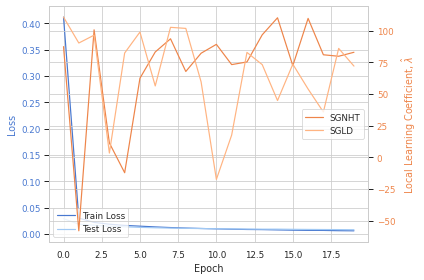

In [33]:
plot_lambda_vs_epochs(train_losses_toy_xp1_1, val_losses_toy_xp1_1, rlct_estimates_sgnht, rlct_estimates_sgld)

##### 1.2 XP1 - labels set $\mathcal{Card} = 2$ - $\mathcal{L}abels=\{2, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## definition of the transformation to apply to dataset


## Load train data
batch_size = 512

train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_2_2)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 2
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}

model_toy, criterion_toy, optimizer_toy = models_factory(model_type="toy_model",
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, criterion_resnet, optimizer_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_2 = []
val_losses_resnet_xp1_2 = []
models_resnet_xp1_2 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_2.append(train_loss)
    val_losses_resnet_xp1_2.append(val_loss)
    models_resnet_xp1_2 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_2, "XP1/card_2-case_2/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_2 = []
val_losses_toy_xp1_2 = []
models_toy_xp1_2 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_2.append(train_loss)
    val_losses_toy_xp1_2.append(val_loss)
    models_toy_xp1_2 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_2, "XP1/card_2-case_2/toy_models.pth")

##### 1.3 XP1 - labels set $\mathcal{Card} = 2$ - $\mathcal{L}abels=\{4, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## definition of the transformation to apply to dataset


## Load train data
batch_size = 512

train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_2_3)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 2
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}

model_toy, criterion_toy, optimizer_toy = models_factory(model_type="toy_model",
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, criterion_resnet, optimizer_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_3 = []
val_losses_resnet_xp1_3 = []
models_resnet_xp1_3 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_3.append(train_loss)
    val_losses_resnet_xp1_3.append(val_loss)
    models_resnet_xp1_3 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_3, "XP1/card_2-case_3/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_3 = []
val_losses_toy_xp1_3 = []
models_toy_xp1_3 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_3.append(train_loss)
    val_losses_toy_xp1_3.append(val_loss)
    models_toy_xp1_3 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_3, "XP1/card_2-case_3/toy_models.pth")

##### 1.4 XP1 - labels set $\mathcal{Card} = 2$ - $\mathcal{L}abels=\{5, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## definition of the transformation to apply to dataset


## Load train data
batch_size = 512

train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_2_4)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 2
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}

model_toy, criterion_toy, optimizer_toy = models_factory(model_type="toy_model",
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, criterion_resnet, optimizer_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_4 = []
val_losses_resnet_xp1_4 = []
models_resnet_xp1_4 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_4.append(train_loss)
    val_losses_resnet_xp1_4.append(val_loss)
    models_resnet_xp1_4 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_4, "XP1/card_2-case_4/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_4 = []
val_losses_toy_xp1_4 = []
models_toy_xp1_4 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_4.append(train_loss)
    val_losses_toy_xp1_4.append(val_loss)
    models_toy_xp1_4 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_4, "XP1/card_2-case_4/toy_models.pth")

##### 1.5 XP1 - labels set $\mathcal{Card} = 2$ - $\mathcal{L}abels=\{9, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## definition of the transformation to apply to dataset


## Load train data
batch_size = 512

train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_2_5)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 2
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}

model_toy, criterion_toy, optimizer_toy = models_factory(model_type="toy_model",
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, criterion_resnet, optimizer_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_5 = []
val_losses_resnet_xp1_5 = []
models_resnet_xp1_5 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_5.append(train_loss)
    val_losses_resnet_xp1_5.append(val_loss)
    models_resnet_xp1_5 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_5, "XP1/card_2-case_5/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_5 = []
val_losses_toy_xp1_5 = []
models_toy_xp1_5 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_5.append(train_loss)
    val_losses_toy_xp1_5.append(val_loss)
    models_toy_xp1_5 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_5, "XP1/card_2-case_5/toy_models.pth")

### Settings and runs label sets $Card(\mathcal{L}abels)=3$

* Labels modification and data loader
* Toy model for 3 classes
* Resnet18 model for 3 classes

In [ ]:
# keys are the original label, values are the new labels
# [{2, 6, other} ; {3, 6, other} ; {0, 4, other} ; {8, 9, other} ; {5, 7, other}]
map_label_card_3_1 = {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 2, 7: 0, 8: 0, 9: 0}
map_label_card_3_2 = {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 2, 7: 0, 8: 0, 9: 0}
map_label_card_3_3 = {0: 1, 1: 0, 2: 0, 3: 0, 4: 2, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_3_4 = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 2}
map_label_card_3_5 = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 2, 8: 0, 9: 0}

##### 2.1 XP1 - labels set $\mathcal{Card} = 3$ - $\mathcal{L}abels=\{2, 6, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_3_1)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

model_toy, criterion_toy, optimizer_toy = models_factory(model_type="toy_model",
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, criterion_resnet, optimizer_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_6 = []
val_losses_resnet_xp1_6 = []
models_resnet_xp1_6 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_6.append(train_loss)
    val_losses_resnet_xp1_6.append(val_loss)
    models_resnet_xp1_6 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_6, "XP1/card_3-case_1/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_6 = []
val_losses_toy_xp1_6 = []
models_toy_xp1_6 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_6.append(train_loss)
    val_losses_toy_xp1_6.append(val_loss)
    models_toy_xp1_6 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_6, "XP1/card_3-case_1/toy_models.pth")

##### 2.2 XP1 - labels set $\mathcal{Card} = 3$ - $\mathcal{L}abels=\{3, 6, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_3_2)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

model_toy, criterion_toy, optimizer_toy = models_factory(model_type="toy_model",
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, criterion_resnet, optimizer_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_7 = []
val_losses_resnet_xp1_7 = []
models_resnet_xp1_7 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_7.append(train_loss)
    val_losses_resnet_xp1_7.append(val_loss)
    models_resnet_xp1_7 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_7, "XP1/card_3-case_2/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_7 = []
val_losses_toy_xp1_7 = []
models_toy_xp1_7 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_7.append(train_loss)
    val_losses_toy_xp1_7.append(val_loss)
    models_toy_xp1_7 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_7, "XP1/card_3-case_2/toy_models.pth")

##### 2.3 XP1 - labels set $\mathcal{Card} = 3$ - $\mathcal{L}abels=\{0, 4, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_3_3)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

model_toy, criterion_toy, optimizer_toy = models_factory(model_type="toy_model",
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, criterion_resnet, optimizer_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_8 = []
val_losses_resnet_xp1_8 = []
models_resnet_xp1_8 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_8.append(train_loss)
    val_losses_resnet_xp1_8.append(val_loss)
    models_resnet_xp1_8 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_8, "XP1/card_3-case_3/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_8 = []
val_losses_toy_xp1_8 = []
models_toy_xp1_8 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_8.append(train_loss)
    val_losses_toy_xp1_8.append(val_loss)
    models_toy_xp1_8 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_8, "XP1/card_3-case_3/toy_models.pth")

##### 2.4 XP1 - labels set $\mathcal{Card} = 3$ - $\mathcal{L}abels=\{8, 9, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_3_4)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

model_toy, criterion_toy, optimizer_toy = models_factory(model_type="toy_model",
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, criterion_resnet, optimizer_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_9 = []
val_losses_resnet_xp1_9 = []
models_resnet_xp1_9 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_9.append(train_loss)
    val_losses_resnet_xp1_9.append(val_loss)
    models_resnet_xp1_9 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_9, "XP1/card_3-case_4/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_9 = []
val_losses_toy_xp1_9 = []
models_toy_xp1_9 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_9.append(train_loss)
    val_losses_toy_xp1_9.append(val_loss)
    models_toy_xp1_9 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_9, "XP1/card_3-case_4/toy_models.pth")

##### 2.5 XP1 - labels set $\mathcal{Card} = 3$ - $\mathcal{L}abels=\{5, 7, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_3_5)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

model_toy, criterion_toy, optimizer_toy = models_factory(model_type="toy_model",
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, criterion_resnet, optimizer_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_10 = []
val_losses_resnet_xp1_10 = []
models_resnet_xp1_10 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_10.append(train_loss)
    val_losses_resnet_xp1_10.append(val_loss)
    models_resnet_xp1_10 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_10, "XP1/card_3-case_5/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_10 = []
val_losses_toy_xp1_10 = []
models_toy_xp1_10 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_10.append(train_loss)
    val_losses_toy_xp1_10.append(val_loss)
    models_toy_xp1_10 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_10, "XP1/card_3-case_5/toy_models.pth")

### Settings and runs label sets $Card(\mathcal{L}abels)=4$

* Labels modification and data loader
* Toy model for 4 classes
* Resnet18 model for 4 classes

In [ ]:
# keys are the original label, values are the new labels
# [{2, 6, other} ; {3, 6, other} ; {0, 4, other} ; {8, 9, other} ; {5, 7, other}]
map_label_card_4_1 = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_4_2 = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_4_3 = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_4_4 = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_4_5 = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

### Settings and runs label sets $Card(\mathcal{L}abels)=5$

* Labels modification and data loader
* Toy model for 5 classes
* Resnet18 model for 5 classes

### Settings and runs label sets $Card(\mathcal{L}abels)=10$

* Labels modification and data loader
* Toy model for 10 classes
* Resnet18 model for 10 classes

## Displays λ 𝑣𝑠 $\mathcal{L}$𝑎𝑏𝑒𝑙𝑠

In [ ]:
sns.set_style("whitegrid")

fig, ax1 = plt.subplots()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=PRIMARY)
ax1.plot(train_losses, label="Train Loss", color=PRIMARY)
ax1.plot(test_losses, label="Test Loss", color=PRIMARY_LIGHT)
ax1.tick_params(axis="y", labelcolor=PRIMARY)
ax1.legend(loc="lower left")

ax2 = ax1.twinx()
ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
ax2.plot(rlct_estimates_sgnht, label="SGNHT", color=SECONDARY)
ax2.plot(rlct_estimates_sgld, label="SGLD", color=SECONDARY_LIGHT)
ax2.tick_params(axis="y", labelcolor=SECONDARY)
ax2.legend(loc="center right")

fig.tight_layout()
plt.show()